In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
import tensorflow as tf
import pandas as pd 
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, Dot, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [ ]:
#   validation_split=0.2,
#   subset="training",

train = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/tomato/train', image_size=(128, 128), batch_size=32)
#   validation_split=0.2,
#   subset="validation",
val=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/tomato/val', image_size=(128, 128), batch_size=32)

Found 9999 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


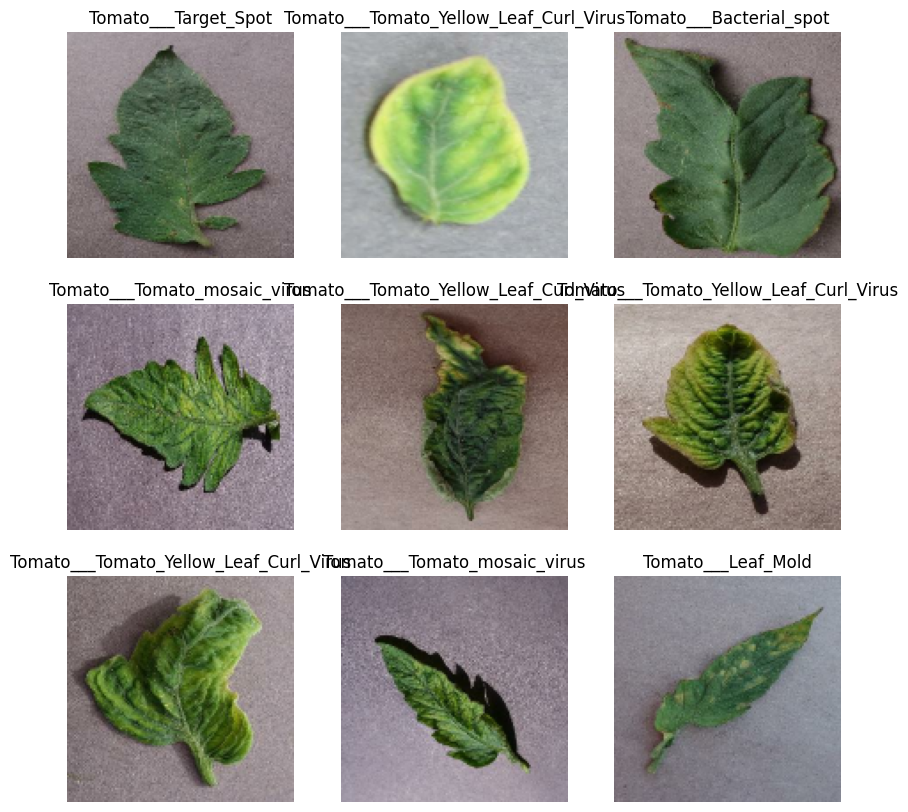

In [ ]:
import matplotlib.pyplot as plt
class_names = train.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3

Preprocessing

In [ ]:
# normalize
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=AUTOTUNE)

high def image rescaling 0-255 color range

In [ ]:
train_datagenerator = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True)

In [ ]:
valid_datagenerator = ImageDataGenerator(rescale = 1./255)

In [ ]:
test_datagenerator = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_path ='/content/drive/MyDrive/tomato/train'

In [ ]:
train_set = train_datagenerator.flow_from_directory(train_path, target_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle=True)

Found 9999 images belonging to 10 classes.


In [ ]:
val_path = '/content/drive/MyDrive/tomato/val'

In [ ]:
valid_set = valid_datagenerator.flow_from_directory(val_path, target_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle=True)

Found 1000 images belonging to 10 classes.


In [ ]:
#test dataset making from train dataset
test_set = test_datagenerator.flow_from_directory(train_path, target_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle=True)

Found 9999 images belonging to 10 classes.


In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

building resnet152

In [ ]:
def model():
  model = ResNet152V2(input_shape=(256, 256, 3), include_top=False)
  for layers in model.layers[:140]:
    layers.trainable = False
  for layers in model.layers[140:]:
    layers.trainalbe = True

  out = model.output
  out = GlobalAveragePooling2D()(out)
  out = Dense(1000, activation='relu')(out)
  pred = Dense(10, activation='softmax')(out)

  model = Model(inputs = model.input, outputs = pred)
  return model

In [ ]:
resnet152 = model()

234545216/234545216 [==============================] - 1s 0us/step


Early Stopping - Stop training when a monitored metric has stopped improving.

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', verbose=1, patience=4, mode='auto')
lr = ReduceLROnPlateau(monitor='loss',verbose=1,patience=2,min_lr=0.00001)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
resnet152.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy"]
)

epochs = 20
resnet152_history = resnet152.fit(train_set,
                                steps_per_epoch=len(train_set),  
                                validation_data=valid_set,
                                epochs=epochs,
                                callbacks=[es,lr],
                                validation_steps=len(valid_set),
                                verbose=1
)

Epoch 1/20
127/313 [===========>..................] - ETA: 20:52 - loss: 2.2964 - accuracy: 0.1690

In [ ]:
val_score = resnet152.evaluate(valid_set)
val_score

In [ ]:
test_score = resnet152.evaluate(test_set)
test_score

In [ ]:
#loss
plt.plot(resnet152_history.history['loss'], label='train loss')
plt.plot(resnet152_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.plot(resnet152_history.history['accuracy'], label='train acc')
plt.plot(resnet152_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
class_names = list(train_set.class_indices.keys())
class_names

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i])
  img_array = tf.expand_dims(img_array, 0)

  predictions = resnet152.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_set:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
        
    predicted_class, confidence = predict(resnet152, images[i])
    index = labels[i].argmax(axis=0)
    actual_class = class_names[index] 
        
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
    plt.axis("off")
  break

In [ ]:
from sklearn.metrics import classification_report

x_val, y_val = valid_set.next()

y_pred = resnet152.predict(x_val).round()
target_names = [f"{class_names[i]}" for i in range(10)]
print(classification_report(y_val, y_pred, target_names=target_names))